# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## October 2021

<br>

Competition Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goal: Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. 

Inference Problem:  Given known variables about a house, accurately predict its sale price.

Deliverable: Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Import modules

In [1]:
# basics
import math
import os 

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# linear modeling
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


Load in the data

In [2]:
# optional directory set-up
working_dir = !pwd
train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

In [3]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (1460, 81)
test shape: (1459, 80)


## Data cleaning

Deal with missing values

In [4]:
print("Count number of missing values per variable:")
print(train.isnull().sum()[train.isnull().sum() != 0])

# function to clean the missing values
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df

train = na_clean(train)
test = na_clean(test)

# make sure there are no more missing values
print("\nNumber of missing values after running na_clean()")
print("Missing values in train: {}".format(train.isnull().sum().sum()))
print("Missing values in test: {}".format(test.isnull().sum().sum()))

Count number of missing values per variable:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Number of missing values after running na_clean()
Missing values in train: 0
Missing values in test: 0


## Feature Engineering

Simplifying the data for any future model we use

In [5]:
# keep adapting this formula to change how we feature engineer
def feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        "LowQualFinSF", # hardly any variation
        "LandSlope", # not much variation
        "PoolArea", # binarized above
        "MiscVal", # not much variation
        "Utilities", # only 1 obs in training data different from regular
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df

In [6]:
# run function on test and train
train = feature_eng(train)
test = feature_eng(test, test_data=True)

# Modeling

## Linear Model

Function to prep data for a very baseline linear model

In [7]:
def lm_df_clean(df):

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
              'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms']

    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)
    
    return df

Get train/test data all ready

In [8]:
X_train = lm_df_clean(train)
X_test = lm_df_clean(test)
Y_train = train.SalePrice
Y_test = sample.SalePrice

Baseline linear model is very overfit

In [9]:
# Decent R2
from sklearn.linear_model import LinearRegression
lr_1 = LinearRegression(fit_intercept=True)
lr_1.fit(X_train,Y_train)

print("Fit on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))


Fit on training data: 0.850
Fit on testing data: -17.593


Same feature set with a baseline RandomForest is also overfit

In [10]:
dt = DecisionTreeRegressor(random_state = 0)
dt.fit(X_train, Y_train)

print("Fit on training data: {:.3f}".format(dt.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(dt.score(X_test ,Y_test)))

Fit on training data: 1.000
Fit on testing data: -18.977


Basic linear model with single coefficient

In [11]:
#Simplest possible model - Chose variable with highest coefficient from initial correlation matrix

X_train_2 = train.drop(train.columns.difference(['OverallQual']), 1)
X_test_2 = test.drop(test.columns.difference(['OverallQual']), 1)
Y_train = train.SalePrice
Y_test = sample.SalePrice

lr_2 = LinearRegression(fit_intercept=True)
lr_2.fit(X_train_2,Y_train)

print("Fit on training data: {:.3f}".format(lr_2.score(X_train_2,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_2.score(X_test_2 ,Y_test)))

Fit on training data: 0.626
Fit on testing data: -14.882


## Random forest with cross validation

In [12]:
# preprocess the data
train_dummies = pd.get_dummies(train)

# create the train and test splits
dev_train, dev_test = train_test_split(train_dummies, test_size=0.3, random_state=1)

# initialize model
rf = RandomForestRegressor()

# specify hyperparameters to tune
# first use RandomizedSearchCV to narrow down list
grid_random = {
    "n_estimators": np.arange(100, 601, 200), 
    'max_features': ['auto', 'sqrt'], 
    'max_depth': np.arange(1, 11, 3), 
    'min_samples_split': [10, 20, 30],
}

# now randomly try out these hyperparameters to find the best
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = grid_random,
    n_iter = 50, 
    cv = 3,
    random_state = 1,
    n_jobs = -1 
)

# random search through a few parameter options
results_random = rf_random.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# check out the best parameters
print(results_random.best_params_)
# {'n_estimators': 500, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 10}

{'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 10}


In [13]:
# now run grid search on a smaller range of values
grid = {
    "n_estimators": [500, 600],
    'max_depth': [10, 20, 40],
    'min_samples_split': [5, 10],
}

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto')

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 3)

# run the search:
results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# check out the best parameters
print(results.best_params_)
# {'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 500}

{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 500}


In [14]:
# finally, run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 500,
    max_depth = 40, 
    max_features = 'auto',
    min_samples_split = 5,  
    bootstrap = True, 
    )

# fit the model
rf_reg.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# evaluate it's performance on the unforseen testing set
yhat = rf_reg.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']))
resids = yhat - dev_test.LogSalePrice


# evaluate rmse and mae on the testing data
print("MAE: " + str(round(np.mean(resids.apply(lambda x: math.fabs(x))),4)))
print("RMSE: " + str(round(np.mean(resids**2)**.5,4)))
# MAE: 0.0999
# RMSE: 0.154

MAE: 0.1001
RMSE: 0.1546


In [15]:
# score on train
rf_train_score = rf_reg.score(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
print("Score on train: {:.3f}".format(rf_train_score))

# score on test/dev
rf_dev_score = rf_reg.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice)
print("Score on test: {:.3f}".format(rf_dev_score))

Score on train: 0.975
Score on train: 0.874


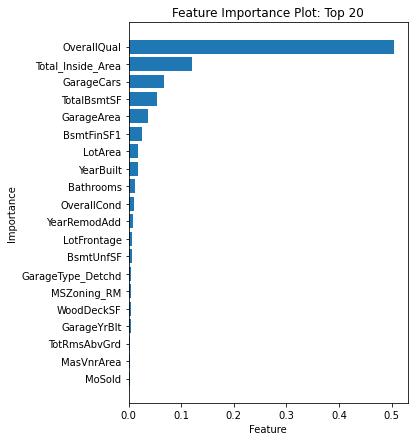

In [42]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")
